In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras import regularizers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout 
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import random

C:\Users\User\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Preprocessing

In [2]:
data=[]
labels=[]
Parasitized=os.listdir("Parasitized/")
for a in Parasitized:
    try:
        image=cv2.imread("Parasitized/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Uninfected=os.listdir("Uninfected/")
for b in Uninfected:
    try:
        image=cv2.imread("Uninfected/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")

In [24]:
len(Parasitized)

13780

In [25]:
len(Uninfected)

13780

In [26]:
len(labels)

27558

In [29]:
np.unique(labels)

array([0, 1])

In [33]:
pd.DataFrame(labels)[0].value_counts()

0
0    13779
1    13779
Name: count, dtype: int64

In [27]:
len(data)

27558

In [3]:
Cells=np.array(data)
labels=np.array(labels)

In [4]:
pd.DataFrame(zip(Cells,labels)).head()

,0,1
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0


In [5]:
np.save("Cells",Cells)
np.save("labels",labels)

In [6]:
Cells=np.load("Cells.npy")
labels=np.load("labels.npy")

In [7]:
s=np.arange(Cells.shape[0])
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

In [8]:
num_classes=len(np.unique(labels))
len_data=len(Cells)

In [9]:
num_classes, len_data

(2, 27558)

In [10]:
(x_train,x_test)=Cells[(int)(0.1*len_data):],Cells[:(int)(0.1*len_data)]
x_train = x_train.astype('float32')/255 #normalizing by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [11]:
(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

In [12]:
#One hot encoding as classifier has multiple classes
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

# Regularization Techniques

### L1 - L2 

In [13]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())

#l2 regularizer
model.add(Dense(500,kernel_regularizer=regularizers.l2(0.01),activation="relu"))

model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

### Droptout 

In [14]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
# 1st dropout
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
# 2nd dropout
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

### Data Augmentation

In [15]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

### Early Stopping

In [16]:
from keras.callbacks import EarlyStopping
earlystop= EarlyStopping(monitor='val_accuracy', patience=3)
epochs = 20 # 
batch_size = 256

# Implementation

In [17]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))

# 1st dropout
model.add(Dropout(0.2))
model.add(Flatten())

#l2 regularizer
model.add(Dense(500,kernel_regularizer=regularizers.l2(0.01),activation="relu"))

# 2nd dropout
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 50, 50, 16)        208       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 25, 25, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 25, 25, 32)        2080      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 64)        8256      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 6, 64)         

In [18]:
# Compiling model
# compile the model with loss as categorical_crossentropy and using adam optimizer you can test result by trying RMSProp as well as Momentum
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
# Fit the model
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[earlystop])

C:\Users\User\AppData\Local\Temp\ipykernel_2420\686497908.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/20
96/96 [==============================] - 37s 374ms/step - loss: 1.8070 - accuracy: 0.5980 - val_loss: 0.6343 - val_accuracy: 0.6737
Epoch 2/20
96/96 [==============================] - 40s 414ms/step - loss: 0.6067 - accuracy: 0.7012 - val_loss: 0.5683 - val_accuracy: 0.7724
Epoch 3/20
96/96 [==============================] - 37s 389ms/step - loss: 0.5239 - accuracy: 0.7913 - val_loss: 0.4155 - val_accuracy: 0.8672
Epoch 4/20
96/96 [==============================] - 37s 388ms/step - loss: 0.4009 - accuracy: 0.8736 - val_loss: 0.3696 - val_accuracy: 0.9122
Epoch 5/20
96/96 [==============================] - 38s 392ms/step - loss: 0.3461 - accuracy: 0.8963 - val_loss: 0.2710 - val_accuracy: 0.9143
Epoch 6/20
96/96 [==============================] - 37s 389ms/step - loss: 0.3085 - accuracy: 0.9080 - val_loss: 0.2559 - val_accuracy: 0.9256
Epoch 7/20
96/96 [==============================] - 38s 391ms/step - loss: 0.2861 - accuracy: 0.9151 - val_loss: 0.2306 - val_accuracy: 0.9318

In [20]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

87/87 [==============================] - 1s 7ms/step


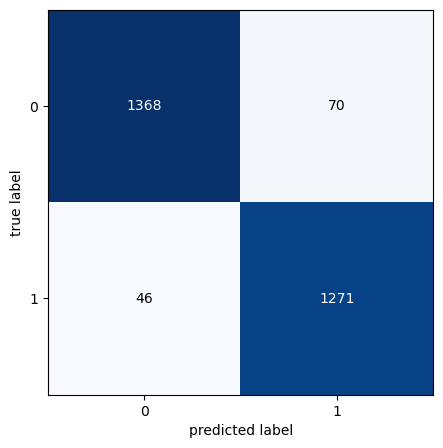

In [21]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [23]:
Recall=1271/(1271+46)
Recall

0.9650721336370539

In [22]:
Precision = 1271/(1271+70)
Precision

0.947800149142431